In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from simulator import Simulation
from tqdm.auto import tqdm
import itertools
import matplotlib as mpl

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
def plot_distribution(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("Tokens")
    # fig.show()
    
    
def plot_alignment(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax)
    ax.set_ylabel("Tokens")
    ax.set_xlabel("Impact")
    ax.set_xticks([])    
    # fig.show()

def plot_all(project_df, save_fp=None):
    fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax[0])
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax[1])
    ax[0].set_xticks([])
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Tokens Allocated")
    ax[1].set_ylabel("")
    ax[1].set_xlabel("Impact")
    ax[1].set_xticks([])
    plt.tight_layout()
    if save_fp:
        plt.savefig(save_fp)
    
    
def analyze_simulation(results, generate_plots=False):
    summary = pd.Series(results).iloc[:-1].apply(lambda x: int(x) if isinstance(x, float) else x)
    data = results['data']
    project_df = pd.DataFrame(data).sort_values(by='token_amount', ascending=False)
    if generate_plots:
        plot_all(project_df)
    return summary

### Normalize to the voting that we will be doing (520k FIL)

In [4]:
## Num Projects > Quorum when sweeping Quorum
quorum_vec = list(np.arange(1, 15+1))
score_fn = ['sum']  # note quorum doesnt depend on score fn
num_applicants = 120
funding_amt = 520000
num_voters = 45
round_funds_available = 540000

# Define funding amount combinations as tuples (min_funding_amt_pct, max_funding_amt_pct)
funding_combinations = [
    (0.01, 0.15),
    (0.01, 0.20),
    (0.05, 0.15),
    (0.05, 0.20),
]

nsim = 25

# Set random seed for reproducibility
random_seed = 42

sim_configs = list(itertools.product(quorum_vec, score_fn, funding_combinations))

results_list = []

In [5]:
# Set random seed for reproducibility
np.random.seed(random_seed)

for sim_config in tqdm(sim_configs):
    # Store raw data for this configuration
    raw_data = []
    q, score_fn, funding_tuple  = sim_config
    
    # Unpack the funding tuple
    min_funding_amt_pct, max_funding_amt_pct = funding_tuple
    
    for i in range(nsim):
        simulation = Simulation()
        
        min_funding_amt_badgeholder = int(min_funding_amt_pct * funding_amt)
        max_funding_amt_badgeholder = int(max_funding_amt_pct * funding_amt)
        min_score_amt = 0

        simulation.initialize_round(
            max_funding=round_funds_available,
            min_project_vote=min_funding_amt_badgeholder,
            max_project_vote=max_funding_amt_badgeholder,
        )
        simulation.randomize_voters(
            num_voters=num_voters, 
            willingness_to_spend=1.0, 
            laziness_factor=0.1, 
            expertise_factor=0.9
        )
        simulation.randomize_projects(
            num_projects=num_applicants
        )

        results = simulation.simulate_voting_and_scoring(
            n=1,
            scoring_method=score_fn,
            quorum=q,
            min_amount=min_score_amt,
            normalize=True,
            count_zero_votes_towards_quorum=True
        )
        summary = analyze_simulation(results, generate_plots=False)
        raw_data.append(summary.num_projects_above_quorum_mean)
    
    # Calculate percentiles and median from raw data
    results_list.append({
        'quorum': q,
        'score_fn': score_fn,
        'funding_tuple': funding_tuple,
        'min_funding_amt_pct': min_funding_amt_pct,
        'max_funding_amt_pct': max_funding_amt_pct,
        'raw_data': raw_data,
        'median': np.median(raw_data),
        'p5': np.percentile(raw_data, 5),
        'p95': np.percentile(raw_data, 95),
        'mean': np.mean(raw_data),
        'std': np.std(raw_data)
    })


  0%|          | 0/60 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame(results_list)

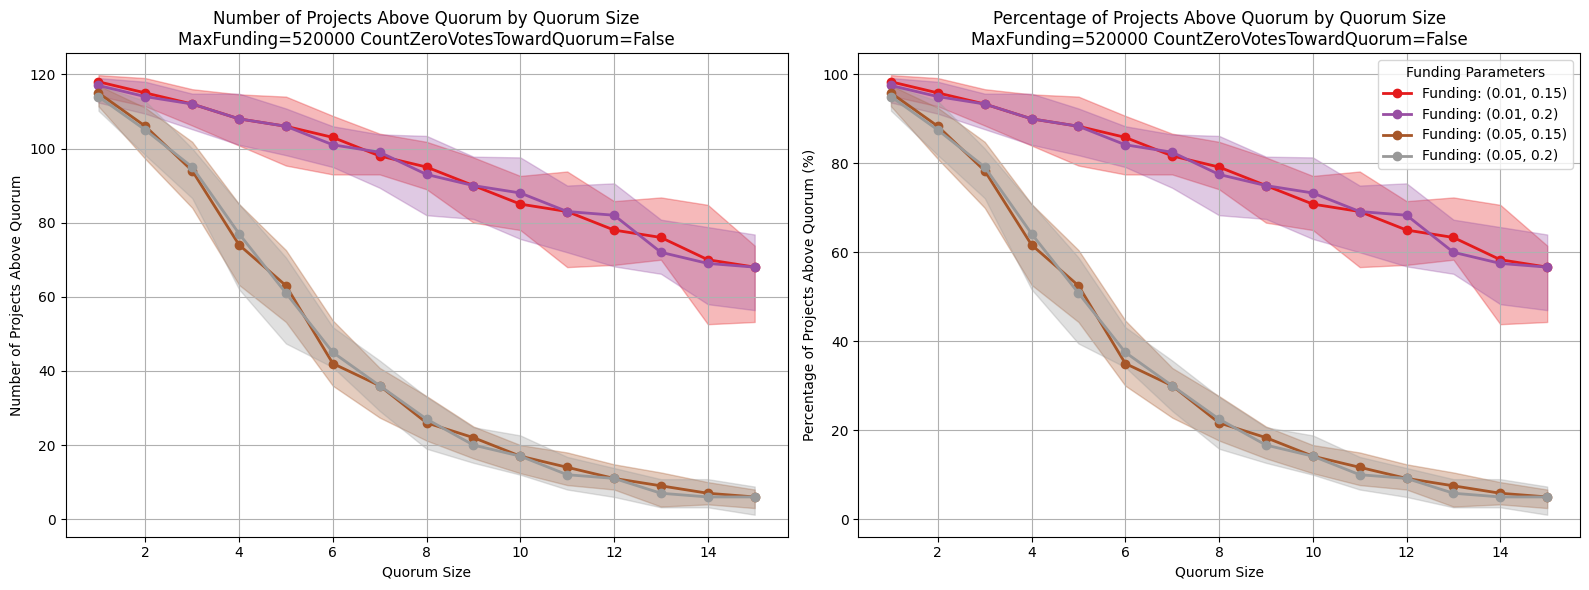

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for different parameter combinations
colors = plt.cm.Set1(np.linspace(0, 1, len(df['funding_tuple'].unique())))

color_idx = 0
# Iterate over unique funding tuples
for funding_tuple in df['funding_tuple'].unique():
    # Filter data for each funding tuple
    filtered_data = df[df['funding_tuple'] == funding_tuple]
    
    # Sort by quorum for proper plotting
    filtered_data = filtered_data.sort_values('quorum')
    
    quorum_values = filtered_data['quorum']
    median_values = filtered_data['median']
    p5_values = filtered_data['p5']
    p95_values = filtered_data['p95']
    
    # Calculate percentage values
    median_pct_values = (median_values / num_applicants) * 100
    p5_pct_values = (p5_values / num_applicants) * 100
    p95_pct_values = (p95_values / num_applicants) * 100
    
    # Create label from funding tuple
    min_funding, max_funding = funding_tuple
    label = f'Funding: ({min_funding}, {max_funding})'
    
    # LEFT PLOT: Absolute number of projects above quorum
    ax1.plot(
        quorum_values,
        median_values,
        label=label,
        color=colors[color_idx],
        linewidth=2,
        marker='o'
    )
    
    ax1.fill_between(
        quorum_values,
        p5_values,
        p95_values,
        alpha=0.3,
        color=colors[color_idx]
    )
    
    # RIGHT PLOT: Percentage of projects above quorum
    ax2.plot(
        quorum_values,
        median_pct_values,
        label=label,
        color=colors[color_idx],
        linewidth=2,
        marker='o'
    )
    
    ax2.fill_between(
        quorum_values,
        p5_pct_values,
        p95_pct_values,
        alpha=0.3,
        color=colors[color_idx]
    )
    
    color_idx += 1

# Left plot labeling
ax1.set_title('Number of Projects Above Quorum by Quorum Size\nMaxFunding=%d CountZeroVotesTowardQuorum=False' % funding_amt)
ax1.set_xlabel('Quorum Size')
ax1.set_ylabel('Number of Projects Above Quorum')
ax1.grid(True)

# Right plot labeling
ax2.set_title('Percentage of Projects Above Quorum by Quorum Size\nMaxFunding=%d CountZeroVotesTowardQuorum=False' % funding_amt)
ax2.set_xlabel('Quorum Size')
ax2.set_ylabel('Percentage of Projects Above Quorum (%)')
ax2.grid(True)

# Add legend to the right plot only
ax2.legend(title='Funding Parameters')

plt.tight_layout()
plt.show()

## Distribution of Funds for Projects Meeting Quorum


In [8]:
# Choose a specific quorum value and funding combination to analyze
chosen_quorum = 5
chosen_funding_tuple = (0.01, 0.15)  # (min_funding_amt_pct, max_funding_amt_pct)
scoring_methods = ['sum', 'mean', 'median']  # Loop over these scoring methods

# Unpack the funding tuple
min_funding_amt_pct, max_funding_amt_pct = chosen_funding_tuple
min_funding_amt_badgeholder = int(min_funding_amt_pct * funding_amt)
max_funding_amt_badgeholder = int(max_funding_amt_pct * funding_amt)
min_score_amt = 0

# Store results for each scoring method
scoring_results = {}

for scoring_method in scoring_methods:
    # Set random seed for each method to ensure fair comparison (same projects/voters)
    np.random.seed(random_seed)
    
    # Run a simulation with the chosen parameters
    simulation = Simulation()

    simulation.initialize_round(
        max_funding=round_funds_available,
        min_project_vote=min_funding_amt_badgeholder,
        max_project_vote=max_funding_amt_badgeholder,
    )
    simulation.randomize_voters(
        num_voters=num_voters, 
        willingness_to_spend=1.0, 
        laziness_factor=0.1, 
        expertise_factor=0.9
    )
    simulation.randomize_projects(
        num_projects=num_applicants
    )

    results = simulation.simulate_voting_and_scoring(
        n=1,
        scoring_method=scoring_method,
        quorum=chosen_quorum,
        min_amount=min_score_amt,
        normalize=True,
        count_zero_votes_towards_quorum=True
    )

    # Extract project data
    data = results['data']
    project_df = pd.DataFrame(data).sort_values(by='token_amount', ascending=False)

    # Check which projects meet quorum (num_votes >= chosen_quorum)
    projects_meeting_quorum = project_df[project_df['num_votes'] >= chosen_quorum].copy()
    
    # Store results
    scoring_results[scoring_method] = {
        'project_df': project_df,
        'projects_meeting_quorum': projects_meeting_quorum,
        'results': results
    }
    
    print(f"\n=== Scoring Method: {scoring_method.upper()} ===")
    print(f"Quorum: {chosen_quorum}")
    print(f"Funding range: {min_funding_amt_pct*100}% - {max_funding_amt_pct*100}%")
    print(f"Total projects: {len(project_df)}")
    print(f"Projects meeting quorum: {len(projects_meeting_quorum)}")
    print(f"Total funds allocated to projects meeting quorum: {projects_meeting_quorum['token_amount'].sum():,.0f} FIL")



=== Scoring Method: SUM ===
Quorum: 5
Funding range: 1.0% - 15.0%
Total projects: 120
Projects meeting quorum: 109
Total funds allocated to projects meeting quorum: 540,000 FIL

=== Scoring Method: MEAN ===
Quorum: 5
Funding range: 1.0% - 15.0%
Total projects: 120
Projects meeting quorum: 109
Total funds allocated to projects meeting quorum: 540,000 FIL

=== Scoring Method: MEDIAN ===
Quorum: 5
Funding range: 1.0% - 15.0%
Total projects: 120
Projects meeting quorum: 109
Total funds allocated to projects meeting quorum: 540,000 FIL


In [9]:
# Display a comparison summary of key metrics across scoring methods
comparison_data = []

for scoring_method in scoring_methods:
    pmq = scoring_results[scoring_method]['projects_meeting_quorum']
    comparison_data.append({
        'Scoring Method': scoring_method.upper(),
        'Projects Meeting Quorum': len(pmq),
        'Total Allocated (FIL)': f"{pmq['token_amount'].sum():,.0f}",
        'Mean Allocation (FIL)': f"{pmq['token_amount'].mean():,.0f}",
        'Median Allocation (FIL)': f"{pmq['token_amount'].median():,.0f}",
        'Std Dev (FIL)': f"{pmq['token_amount'].std():,.0f}",
        'Min Allocation (FIL)': f"{pmq['token_amount'].min():,.0f}",
        'Max Allocation (FIL)': f"{pmq['token_amount'].max():,.0f}",
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Scoring Method,Projects Meeting Quorum,Total Allocated (FIL),Mean Allocation (FIL),Median Allocation (FIL),Std Dev (FIL),Min Allocation (FIL),Max Allocation (FIL)
0,SUM,109,"540,000","4,954","3,303","4,465",652,"20,896"
1,MEAN,109,"540,000","4,954","4,181","2,185","2,797","12,112"
2,MEDIAN,109,"540,000","4,954","4,422","1,290","3,819","10,310"


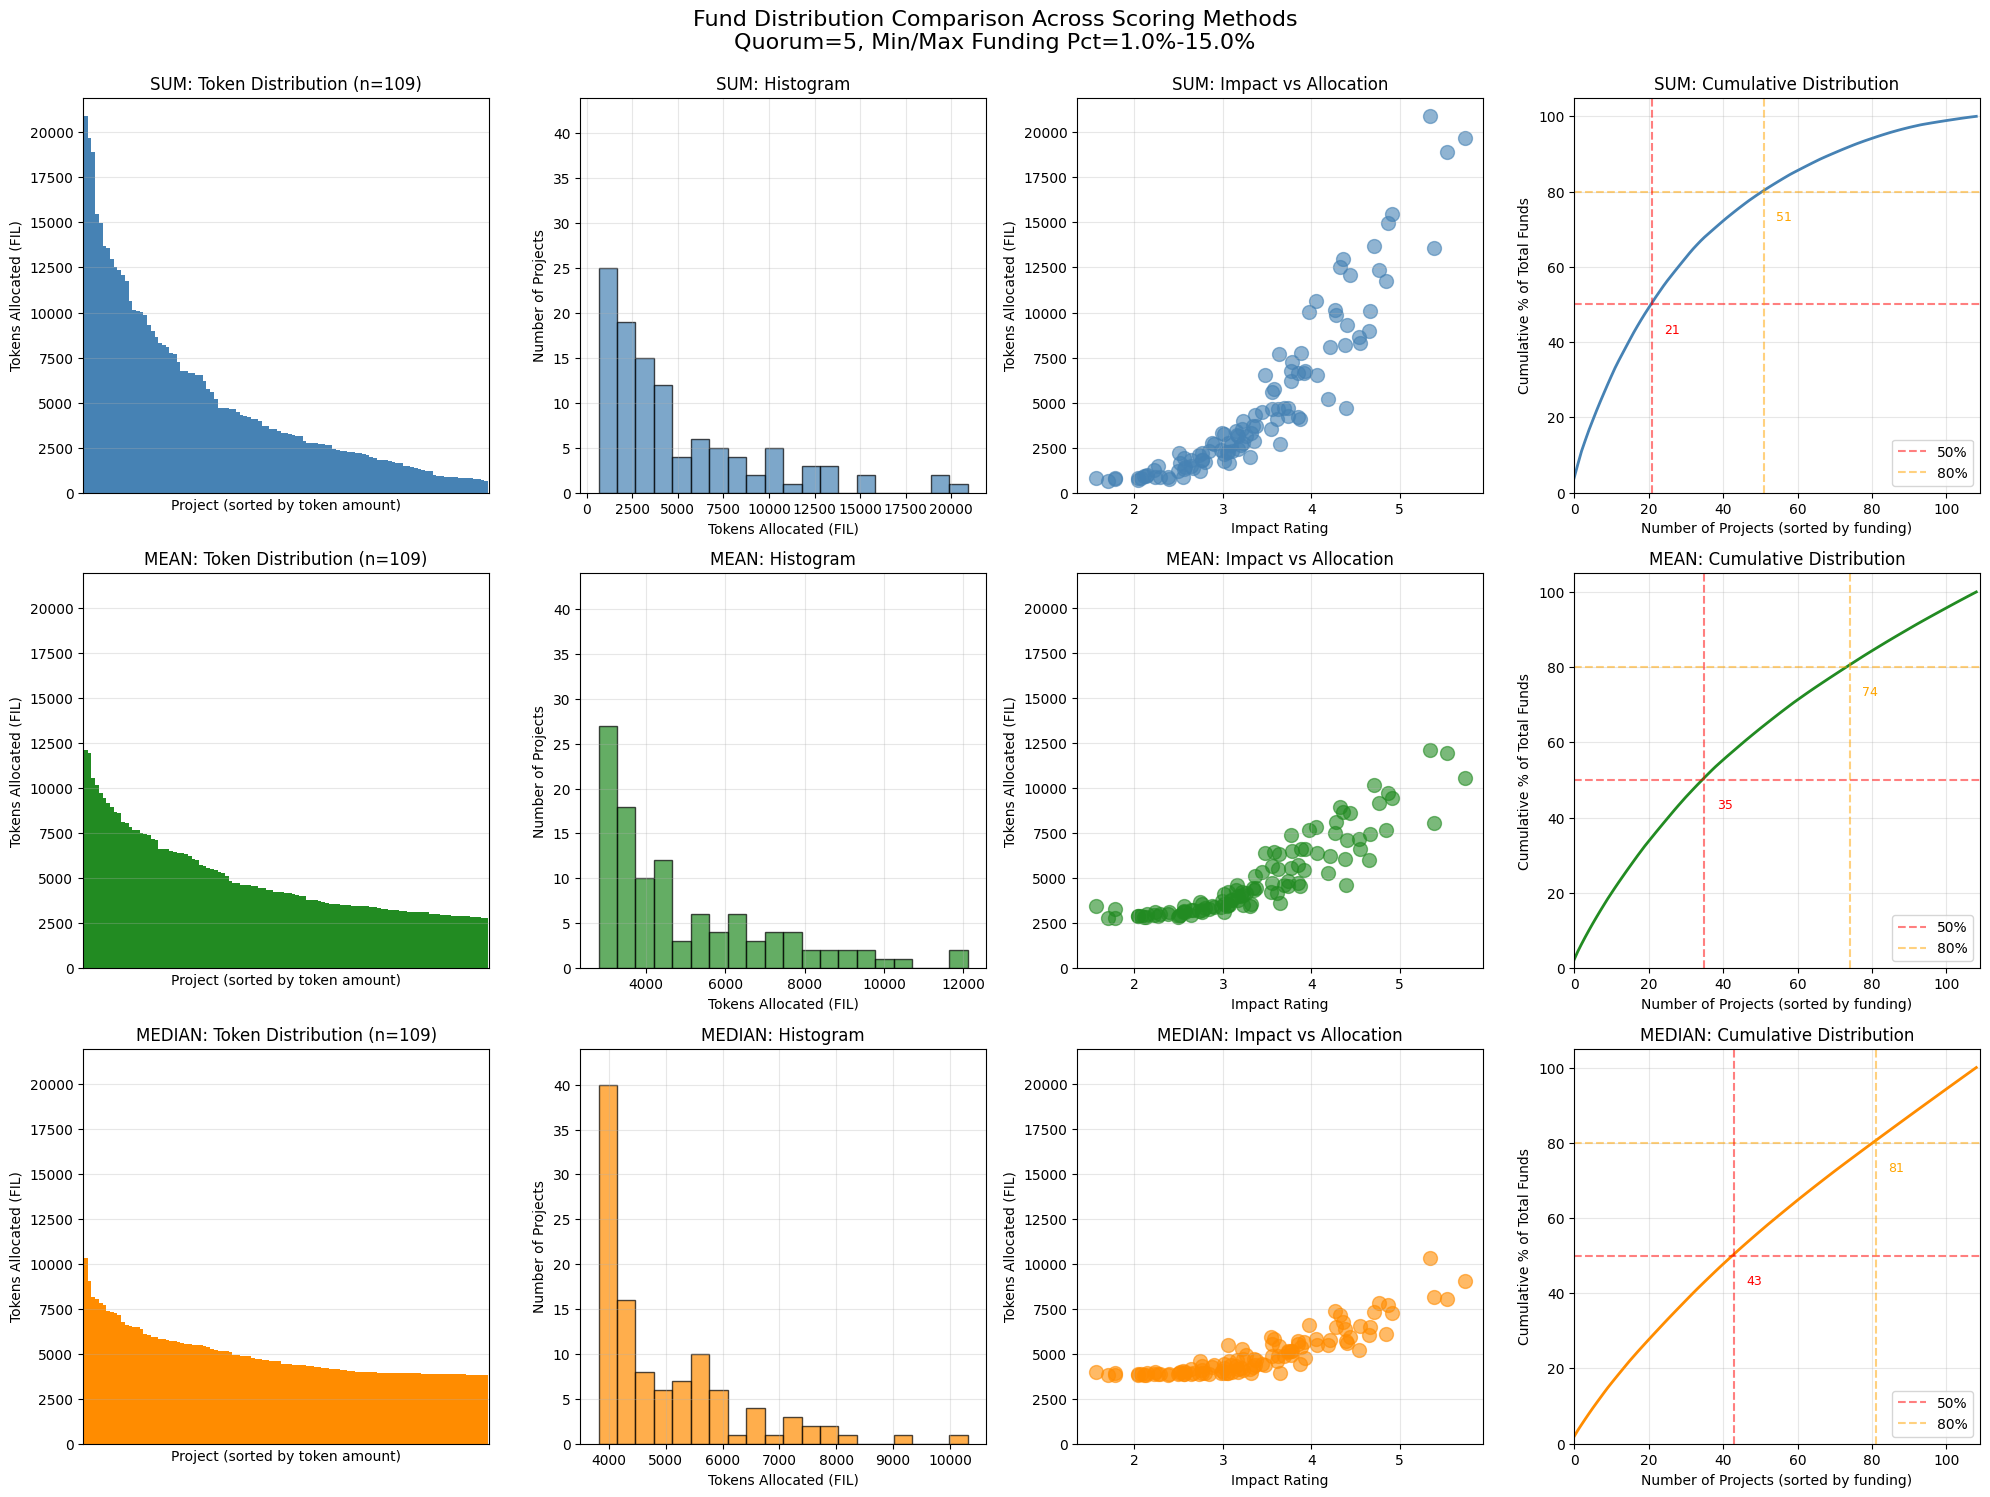


DISTRIBUTION STATISTICS COMPARISON

SUM Scoring Method:
  Projects meeting quorum: 109
  Mean allocation: 4,954 FIL
  Median allocation: 3,303 FIL
  Std deviation: 4,465 FIL
  Min allocation: 652 FIL
  Max allocation: 20,896 FIL
  Top 10% of projects receive: 28.7% of total funding

MEAN Scoring Method:
  Projects meeting quorum: 109
  Mean allocation: 4,954 FIL
  Median allocation: 4,181 FIL
  Std deviation: 2,185 FIL
  Min allocation: 2,797 FIL
  Max allocation: 12,112 FIL
  Top 10% of projects receive: 18.4% of total funding

MEDIAN Scoring Method:
  Projects meeting quorum: 109
  Mean allocation: 4,954 FIL
  Median allocation: 4,422 FIL
  Std deviation: 1,290 FIL
  Min allocation: 3,819 FIL
  Max allocation: 10,310 FIL
  Top 10% of projects receive: 14.8% of total funding



In [10]:
# Create comparison visualizations for all scoring methods
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

colors_map = {'sum': 'steelblue', 'mean': 'forestgreen', 'median': 'darkorange'}

# Calculate global min/max for consistent y-axis scaling
global_max_token = max([scoring_results[sm]['projects_meeting_quorum']['token_amount'].max() 
                        for sm in scoring_methods if len(scoring_results[sm]['projects_meeting_quorum']) > 0])
global_max_hist_count = 0
global_max_projects = max([len(scoring_results[sm]['projects_meeting_quorum']) for sm in scoring_methods])

# First pass to determine histogram y-max
for scoring_method in scoring_methods:
    pmq = scoring_results[scoring_method]['projects_meeting_quorum']
    if len(pmq) > 0:
        hist_counts, _ = np.histogram(pmq['token_amount'], bins=20)
        global_max_hist_count = max(global_max_hist_count, hist_counts.max())

for idx, scoring_method in enumerate(scoring_methods):
    projects_meeting_quorum = scoring_results[scoring_method]['projects_meeting_quorum']
    
    # 1. Bar chart of token distribution for projects meeting quorum
    ax1 = axes[idx, 0]
    projects_meeting_quorum.reset_index(drop=True)['token_amount'].plot(
        kind='bar', width=1, ax=ax1, color=colors_map[scoring_method]
    )
    ax1.set_title(f'{scoring_method.upper()}: Token Distribution (n={len(projects_meeting_quorum)})')
    ax1.set_xlabel('Project (sorted by token amount)')
    ax1.set_ylabel('Tokens Allocated (FIL)')
    ax1.set_xticks([])
    ax1.set_ylim(0, global_max_token * 1.05)  # Set consistent y-scale
    ax1.grid(True, alpha=0.3)

    # 2. Histogram of token amounts
    ax2 = axes[idx, 1]
    ax2.hist(projects_meeting_quorum['token_amount'], bins=20, 
             color=colors_map[scoring_method], edgecolor='black', alpha=0.7)
    ax2.set_title(f'{scoring_method.upper()}: Histogram')
    ax2.set_xlabel('Tokens Allocated (FIL)')
    ax2.set_ylabel('Number of Projects')
    ax2.set_ylim(0, global_max_hist_count * 1.1)  # Set consistent y-scale
    ax2.grid(True, alpha=0.3)

    # 3. Scatter plot: Impact vs Tokens
    ax3 = axes[idx, 2]
    ax3.scatter(projects_meeting_quorum['rating'], projects_meeting_quorum['token_amount'], 
               alpha=0.6, s=100, color=colors_map[scoring_method])
    ax3.set_title(f'{scoring_method.upper()}: Impact vs Allocation')
    ax3.set_xlabel('Impact Rating')
    ax3.set_ylabel('Tokens Allocated (FIL)')
    ax3.set_ylim(0, global_max_token * 1.05)  # Set consistent y-scale
    ax3.grid(True, alpha=0.3)

    # 4. Cumulative distribution
    ax4 = axes[idx, 3]
    sorted_tokens = projects_meeting_quorum['token_amount'].sort_values(ascending=False).values
    if len(sorted_tokens) > 0:
        cumulative_tokens = np.cumsum(sorted_tokens)
        cumulative_pct = (cumulative_tokens / cumulative_tokens[-1]) * 100
        ax4.plot(range(len(cumulative_pct)), cumulative_pct, linewidth=2, 
                color=colors_map[scoring_method])
        ax4.set_title(f'{scoring_method.upper()}: Cumulative Distribution')
        ax4.set_xlabel('Number of Projects (sorted by funding)')
        ax4.set_ylabel('Cumulative % of Total Funds')
        ax4.set_ylim(0, 105)  # Consistent 0-100% scale with some padding
        ax4.set_xlim(0, global_max_projects)  # Set consistent x-scale
        ax4.grid(True, alpha=0.3)
        ax4.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50%')
        ax4.axhline(y=80, color='orange', linestyle='--', alpha=0.5, label='80%')

        # Find where cumulative percentage crosses 50% and 80%
        if len(cumulative_pct) > 0:
            idx_50 = np.argmax(cumulative_pct >= 50) if any(cumulative_pct >= 50) else len(cumulative_pct) - 1
            idx_80 = np.argmax(cumulative_pct >= 80) if any(cumulative_pct >= 80) else len(cumulative_pct) - 1
            ax4.axvline(x=idx_50, color='r', linestyle='--', alpha=0.5)
            ax4.axvline(x=idx_80, color='orange', linestyle='--', alpha=0.5)
            # Offset text to the right for better readability
            text_offset = global_max_projects * 0.03  # 3% offset to the right
            ax4.text(idx_50 + text_offset, 45, f'{idx_50}', ha='left', va='top', fontsize=9, color='r')
            ax4.text(idx_80 + text_offset, 75, f'{idx_80}', ha='left', va='top', fontsize=9, color='orange')
        
        ax4.legend(loc='lower right')

plt.suptitle(f'Fund Distribution Comparison Across Scoring Methods\nQuorum={chosen_quorum}, Min/Max Funding Pct={min_funding_amt_pct*100}%-{max_funding_amt_pct*100}%', 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "="*80)
print("DISTRIBUTION STATISTICS COMPARISON")
print("="*80)

for scoring_method in scoring_methods:
    projects_meeting_quorum = scoring_results[scoring_method]['projects_meeting_quorum']
    sorted_tokens = projects_meeting_quorum['token_amount'].sort_values(ascending=False).values
    
    print(f"\n{scoring_method.upper()} Scoring Method:")
    print(f"  Projects meeting quorum: {len(projects_meeting_quorum)}")
    print(f"  Mean allocation: {projects_meeting_quorum['token_amount'].mean():,.0f} FIL")
    print(f"  Median allocation: {projects_meeting_quorum['token_amount'].median():,.0f} FIL")
    print(f"  Std deviation: {projects_meeting_quorum['token_amount'].std():,.0f} FIL")
    print(f"  Min allocation: {projects_meeting_quorum['token_amount'].min():,.0f} FIL")
    print(f"  Max allocation: {projects_meeting_quorum['token_amount'].max():,.0f} FIL")
    
    # Calculate concentration metrics
    if len(sorted_tokens) > 0:
        top_10_pct_projects = max(1, int(len(projects_meeting_quorum) * 0.1))
        top_10_pct_funding = sorted_tokens[:top_10_pct_projects].sum() / sorted_tokens.sum() * 100
        print(f"  Top 10% of projects receive: {top_10_pct_funding:.1f}% of total funding")

print("\n" + "="*80)


## Laziness & Expertise Factor Analysis

Sweep laziness_factor and expertise_factor to understand their impact on:
- Number of projects meeting quorum
- Token distribution characteristics


In [11]:
# Configuration for laziness/expertise sweep
chosen_quorum_lf = 5
chosen_scoring_method_lf = 'sum'
chosen_funding_tuple_lf = (0.01, 0.15)  # (min_funding_amt_pct, max_funding_amt_pct)

# Parameter ranges to sweep
laziness_factors = [0.1, 0.2, 0.3, 0.4, 0.5]
expertise_factors = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]

# Number of simulations per configuration
nsim_lf = 25
random_seed_lf = 42

# Unpack the funding tuple
min_funding_amt_pct_lf, max_funding_amt_pct_lf = chosen_funding_tuple_lf
min_funding_amt_badgeholder_lf = int(min_funding_amt_pct_lf * funding_amt)
max_funding_amt_badgeholder_lf = int(max_funding_amt_pct_lf * funding_amt)
min_score_amt_lf = 0

# Create all combinations
lf_ef_combinations = list(itertools.product(laziness_factors, expertise_factors))

# Store results
lf_ef_results = []

print(f"Running {len(lf_ef_combinations)} configurations with {nsim_lf} simulations each...")
print(f"Quorum: {chosen_quorum_lf}, Scoring: {chosen_scoring_method_lf}, Funding: {chosen_funding_tuple_lf}")


Running 30 configurations with 25 simulations each...
Quorum: 5, Scoring: sum, Funding: (0.01, 0.15)


In [12]:
# Run simulations for each combination
np.random.seed(random_seed_lf)

for lf, ef in tqdm(lf_ef_combinations):
    # Store raw data for this configuration
    num_projects_above_quorum_data = []
    token_distribution_data = []
    
    for i in range(nsim_lf):
        simulation = Simulation()
        
        simulation.initialize_round(
            max_funding=round_funds_available,
            min_project_vote=min_funding_amt_badgeholder_lf,
            max_project_vote=max_funding_amt_badgeholder_lf,
        )
        simulation.randomize_voters(
            num_voters=num_voters, 
            willingness_to_spend=1.0, 
            laziness_factor=lf, 
            expertise_factor=ef
        )
        simulation.randomize_projects(
            num_projects=num_applicants
        )

        results = simulation.simulate_voting_and_scoring(
            n=1,
            scoring_method=chosen_scoring_method_lf,
            quorum=chosen_quorum_lf,
            min_amount=min_score_amt_lf,
            normalize=True,
            count_zero_votes_towards_quorum=True
        )
        
        # Extract project data
        data = results['data']
        project_df = pd.DataFrame(data).sort_values(by='token_amount', ascending=False)
        projects_meeting_quorum = project_df[project_df['num_votes'] >= chosen_quorum_lf]
        
        # Store metrics
        num_projects_above_quorum_data.append(len(projects_meeting_quorum))
        
        # Store distribution statistics
        if len(projects_meeting_quorum) > 0:
            token_distribution_data.append({
                'mean': projects_meeting_quorum['token_amount'].mean(),
                'median': projects_meeting_quorum['token_amount'].median(),
                'std': projects_meeting_quorum['token_amount'].std(),
                'min': projects_meeting_quorum['token_amount'].min(),
                'max': projects_meeting_quorum['token_amount'].max(),
                'gini': None  # We'll calculate this later if needed
            })
        else:
            token_distribution_data.append({
                'mean': 0, 'median': 0, 'std': 0, 'min': 0, 'max': 0, 'gini': None
            })
    
    # Aggregate results
    lf_ef_results.append({
        'laziness_factor': lf,
        'expertise_factor': ef,
        'num_projects_above_quorum_raw': num_projects_above_quorum_data,
        'num_projects_above_quorum_mean': np.mean(num_projects_above_quorum_data),
        'num_projects_above_quorum_median': np.median(num_projects_above_quorum_data),
        'num_projects_above_quorum_std': np.std(num_projects_above_quorum_data),
        'num_projects_above_quorum_p5': np.percentile(num_projects_above_quorum_data, 5),
        'num_projects_above_quorum_p95': np.percentile(num_projects_above_quorum_data, 95),
        # Token distribution aggregates
        'token_mean_avg': np.mean([d['mean'] for d in token_distribution_data]),
        'token_median_avg': np.mean([d['median'] for d in token_distribution_data]),
        'token_std_avg': np.mean([d['std'] for d in token_distribution_data]),
        'token_min_avg': np.mean([d['min'] for d in token_distribution_data]),
        'token_max_avg': np.mean([d['max'] for d in token_distribution_data]),
    })

print("Simulation complete!")


  0%|          | 0/30 [00:00<?, ?it/s]

Simulation complete!


In [20]:
# Create DataFrame from results
lf_ef_df = pd.DataFrame(lf_ef_results)


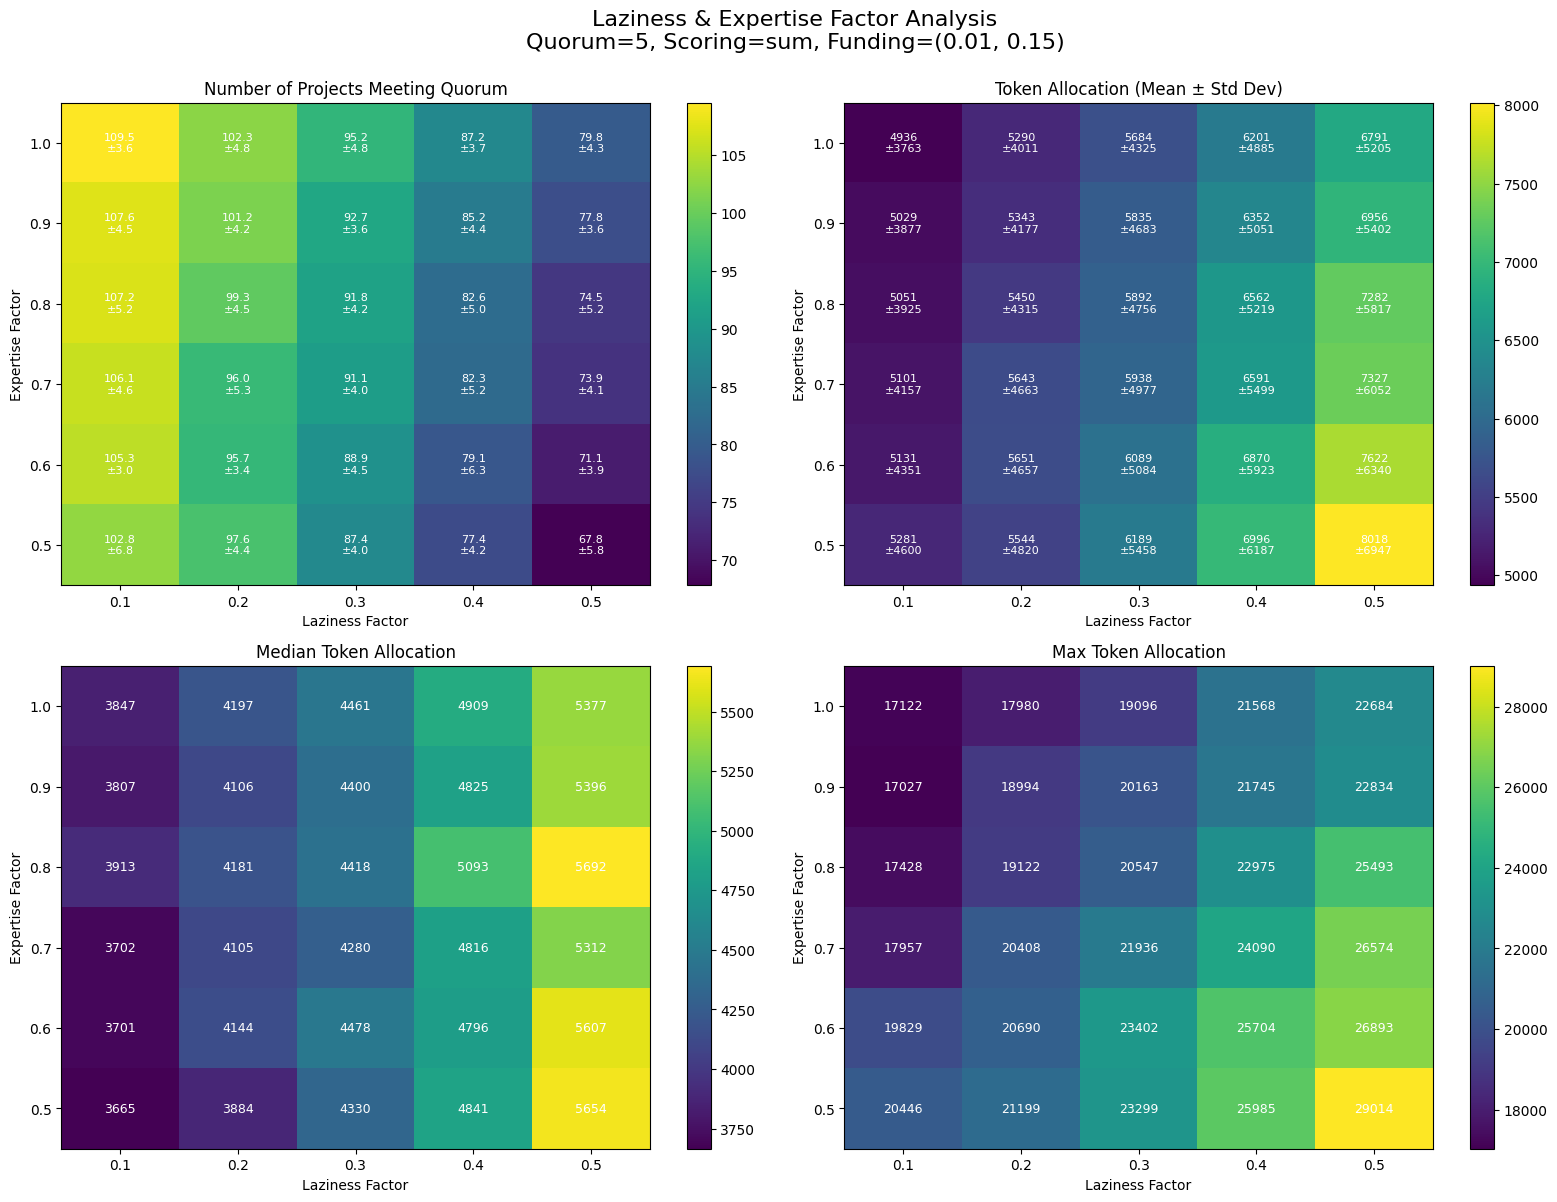

In [23]:
# Create combined heatmap visualizations (mean ± std)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare pivot tables for heatmaps with combined mean ± std
metrics = [
    ('num_projects_above_quorum_mean', 'num_projects_above_quorum_std', 
     'Number of Projects Meeting Quorum', '.1f'),
    ('token_mean_avg', 'token_std_avg', 
     'Token Allocation (Mean ± Std Dev)', '.0f'),
    ('token_median_avg', None, 
     'Median Token Allocation', '.0f'),
    ('token_max_avg', None, 
     'Max Token Allocation', '.0f')
]

for idx, metric_info in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    mean_metric = metric_info[0]
    std_metric = metric_info[1]
    title = metric_info[2]
    fmt = metric_info[3]
    
    # Create pivot table for mean
    pivot_mean = lf_ef_df.pivot(index='expertise_factor', columns='laziness_factor', values=mean_metric)
    
    # Create heatmap using mean values for coloring
    im = ax.imshow(pivot_mean.values, cmap='viridis', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(laziness_factors)))
    ax.set_yticks(np.arange(len(expertise_factors)))
    ax.set_xticklabels(laziness_factors)
    ax.set_yticklabels(expertise_factors)
    
    # Add labels
    ax.set_xlabel('Laziness Factor')
    ax.set_ylabel('Expertise Factor')
    ax.set_title(title)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    
    # Add text annotations with mean ± std if std_metric exists
    if std_metric:
        pivot_std = lf_ef_df.pivot(index='expertise_factor', columns='laziness_factor', values=std_metric)
        for i in range(len(expertise_factors)):
            for j in range(len(laziness_factors)):
                mean_val = pivot_mean.values[i, j]
                std_val = pivot_std.values[i, j]
                label = f'{mean_val:{fmt}}\n±{std_val:{fmt}}'
                text = ax.text(j, i, label,
                              ha="center", va="center", color="w", fontsize=8)
    else:
        for i in range(len(expertise_factors)):
            for j in range(len(laziness_factors)):
                mean_val = pivot_mean.values[i, j]
                label = f'{mean_val:{fmt}}'
                text = ax.text(j, i, label,
                              ha="center", va="center", color="w", fontsize=9)

plt.suptitle(f'Laziness & Expertise Factor Analysis\nQuorum={chosen_quorum_lf}, Scoring={chosen_scoring_method_lf}, Funding={chosen_funding_tuple_lf}',
             fontsize=16, y=0.998)
plt.tight_layout()
plt.show()


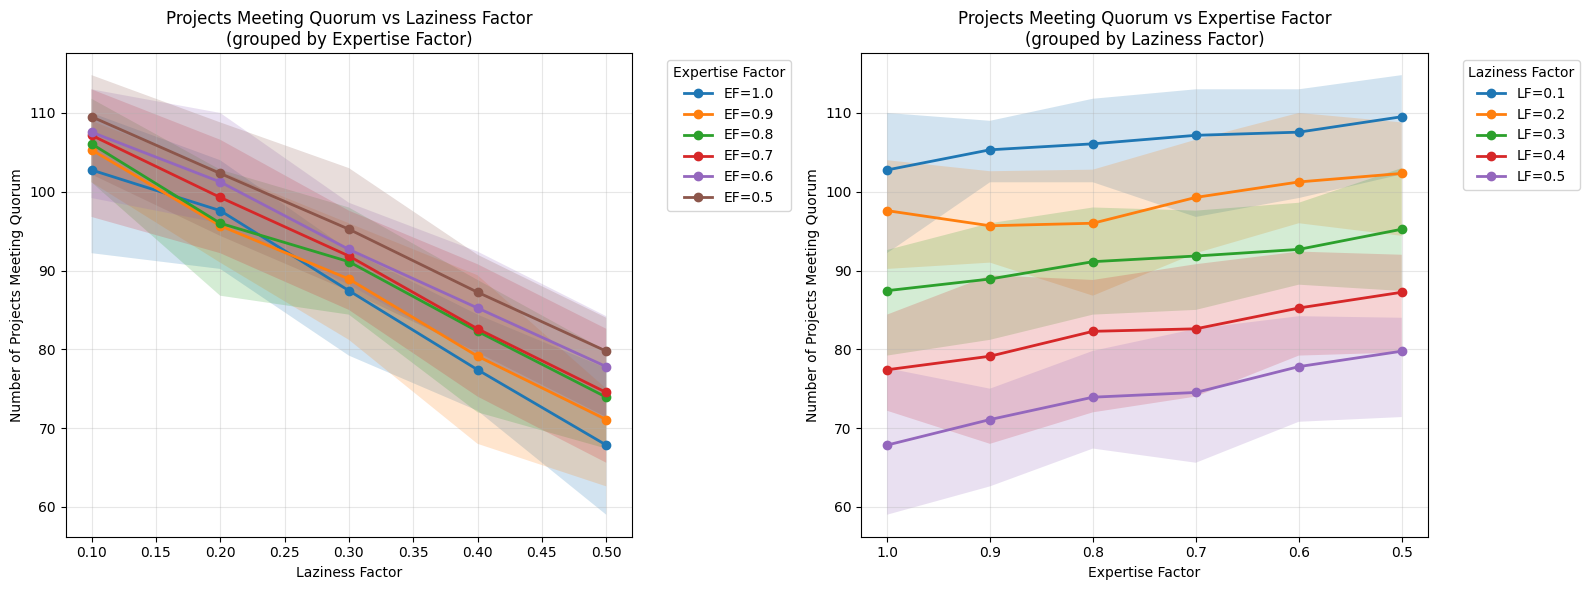

In [22]:
# Line plots showing trends
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Number of projects meeting quorum vs laziness factor (grouped by expertise)
ax1 = axes[0]
for ef in expertise_factors:
    subset = lf_ef_df[lf_ef_df['expertise_factor'] == ef]
    ax1.plot(subset['laziness_factor'], subset['num_projects_above_quorum_mean'], 
             marker='o', label=f'EF={ef}', linewidth=2)
    ax1.fill_between(subset['laziness_factor'],
                     subset['num_projects_above_quorum_p5'],
                     subset['num_projects_above_quorum_p95'],
                     alpha=0.2)

ax1.set_xlabel('Laziness Factor')
ax1.set_ylabel('Number of Projects Meeting Quorum')
ax1.set_title('Projects Meeting Quorum vs Laziness Factor\n(grouped by Expertise Factor)')
ax1.legend(title='Expertise Factor', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# RIGHT: Number of projects meeting quorum vs expertise factor (grouped by laziness)
ax2 = axes[1]
for lf in laziness_factors:
    subset = lf_ef_df[lf_ef_df['laziness_factor'] == lf]
    ax2.plot(subset['expertise_factor'], subset['num_projects_above_quorum_mean'], 
             marker='o', label=f'LF={lf}', linewidth=2)
    ax2.fill_between(subset['expertise_factor'],
                     subset['num_projects_above_quorum_p5'],
                     subset['num_projects_above_quorum_p95'],
                     alpha=0.2)

ax2.set_xlabel('Expertise Factor')
ax2.set_ylabel('Number of Projects Meeting Quorum')
ax2.set_title('Projects Meeting Quorum vs Expertise Factor\n(grouped by Laziness Factor)')
ax2.legend(title='Laziness Factor', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
# Reverse x-axis for expertise (higher expertise on the left)
ax2.invert_xaxis()

plt.tight_layout()
plt.show()


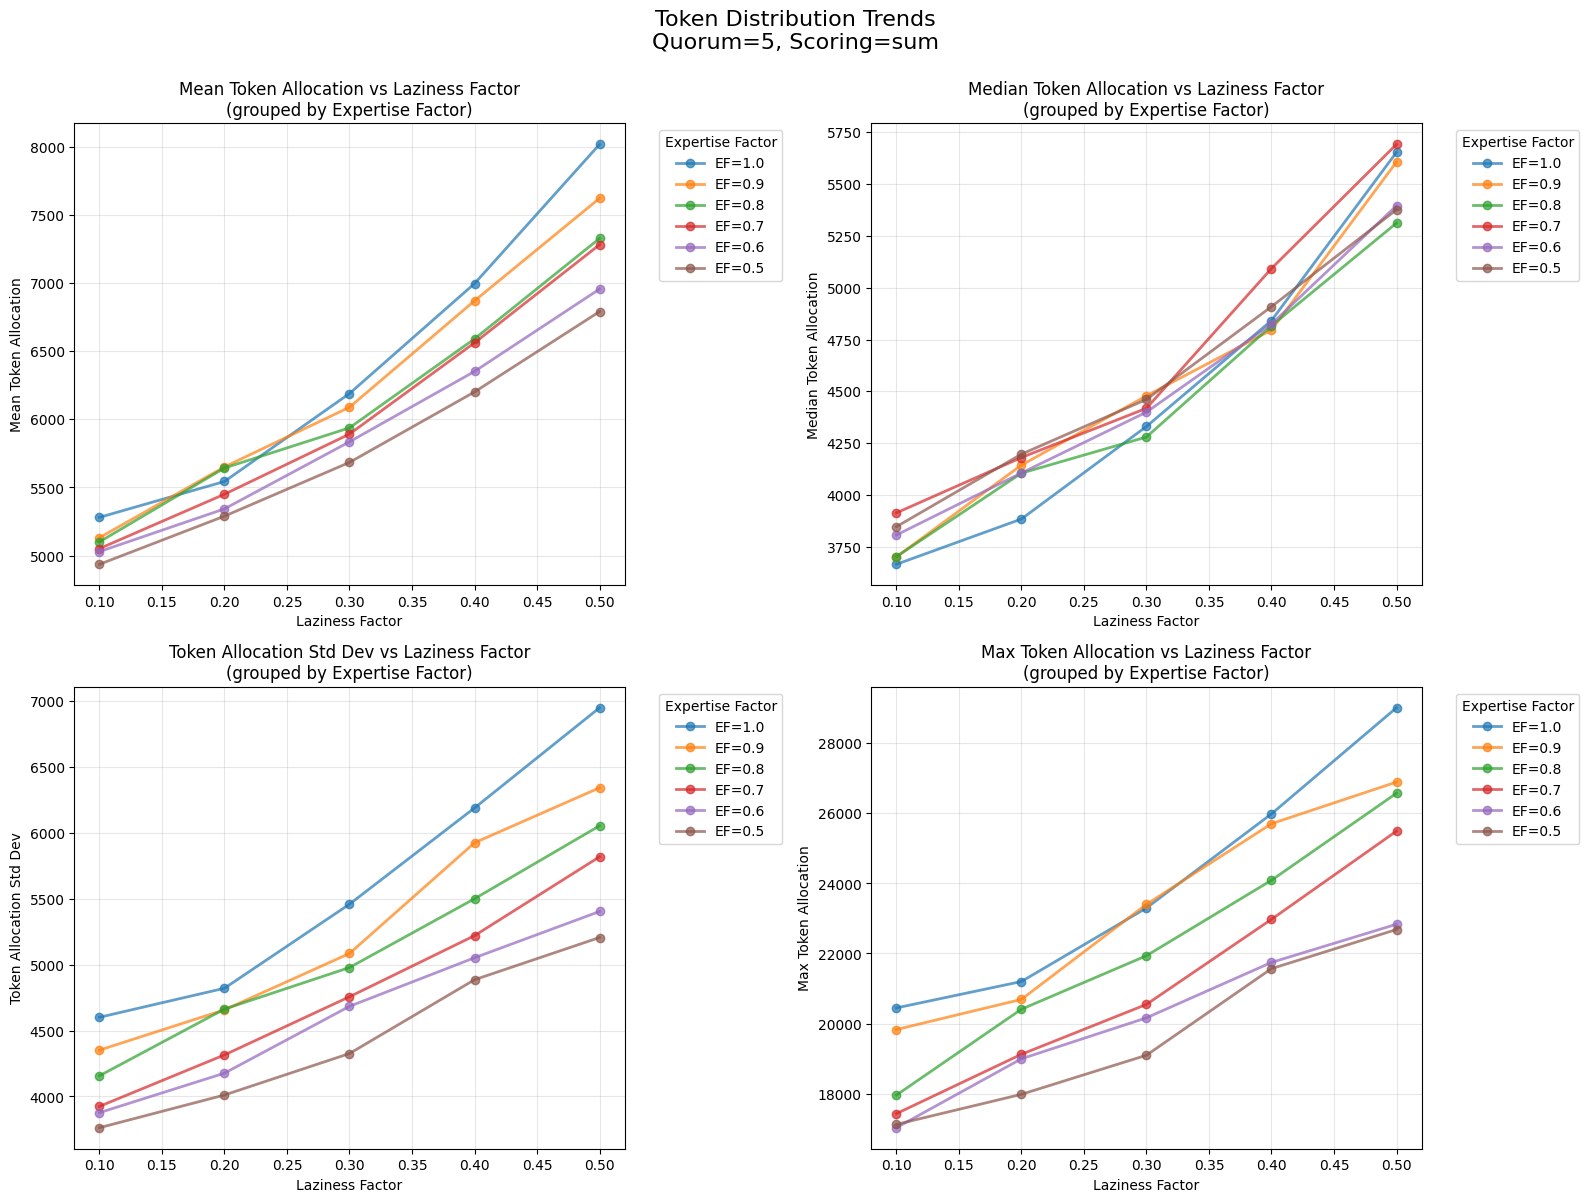

In [16]:
# Token distribution trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot configurations
plots = [
    ('token_mean_avg', 'Mean Token Allocation'),
    ('token_median_avg', 'Median Token Allocation'),
    ('token_std_avg', 'Token Allocation Std Dev'),
    ('token_max_avg', 'Max Token Allocation')
]

for idx, (metric, ylabel) in enumerate(plots):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Plot vs laziness factor (grouped by expertise)
    for ef in expertise_factors:
        subset = lf_ef_df[lf_ef_df['expertise_factor'] == ef]
        ax.plot(subset['laziness_factor'], subset[metric], 
                marker='o', label=f'EF={ef}', linewidth=2, alpha=0.7)
    
    ax.set_xlabel('Laziness Factor')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} vs Laziness Factor\n(grouped by Expertise Factor)')
    ax.legend(title='Expertise Factor', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Token Distribution Trends\nQuorum={chosen_quorum_lf}, Scoring={chosen_scoring_method_lf}',
             fontsize=16, y=0.998)
plt.tight_layout()
plt.show()


In [17]:
# Summary statistics table
summary_table = lf_ef_df[['laziness_factor', 'expertise_factor', 
                          'num_projects_above_quorum_mean', 
                          'num_projects_above_quorum_std',
                          'token_mean_avg', 'token_median_avg', 
                          'token_std_avg', 'token_max_avg']].copy()

summary_table.columns = ['Laziness', 'Expertise', 'Projects (Mean)', 'Projects (Std)', 
                         'Token Mean', 'Token Median', 'Token Std', 'Token Max']

# Format numeric columns
for col in ['Projects (Mean)', 'Token Mean', 'Token Median', 'Token Std', 'Token Max']:
    summary_table[col] = summary_table[col].apply(lambda x: f'{x:.0f}')
summary_table['Projects (Std)'] = summary_table['Projects (Std)'].apply(lambda x: f'{float(x):.2f}')

print("\n" + "="*100)
print("SUMMARY: Laziness & Expertise Factor Impact")
print("="*100)
summary_table



SUMMARY: Laziness & Expertise Factor Impact


,Laziness,Expertise,Projects (Mean),Projects (Std),Token Mean,Token Median,Token Std,Token Max
0,0.1,1.0,103,6.81,5281,3665,4600,20446
1,0.1,0.9,105,2.98,5131,3701,4351,19829
2,0.1,0.8,106,4.59,5101,3702,4157,17957
3,0.1,0.7,107,5.16,5051,3913,3925,17428
4,0.1,0.6,108,4.47,5029,3807,3877,17027
5,0.1,0.5,110,3.62,4936,3847,3763,17122
6,0.2,1.0,98,4.38,5544,3884,4820,21199
7,0.2,0.9,96,3.45,5651,4144,4657,20690
8,0.2,0.8,96,5.31,5643,4105,4663,20408
9,0.2,0.7,99,4.54,5450,4181,4315,19122


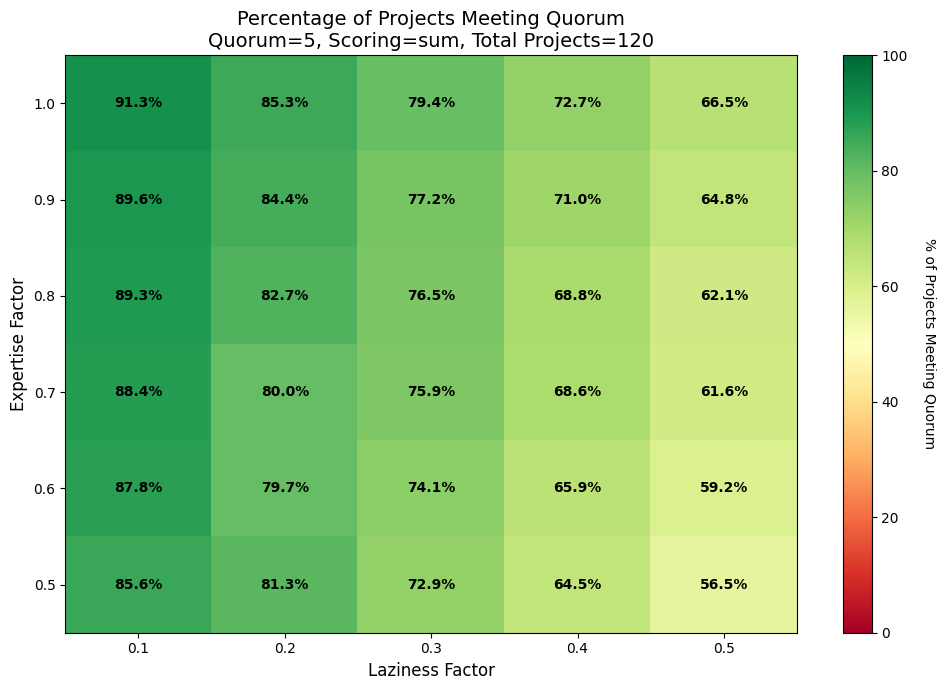

In [18]:
# Percentage of projects meeting quorum
lf_ef_df['pct_projects_above_quorum'] = (lf_ef_df['num_projects_above_quorum_mean'] / num_applicants) * 100

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Create heatmap for percentage
pivot_data = lf_ef_df.pivot(index='expertise_factor', columns='laziness_factor', 
                             values='pct_projects_above_quorum')

im = ax.imshow(pivot_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# Set ticks and labels
ax.set_xticks(np.arange(len(laziness_factors)))
ax.set_yticks(np.arange(len(expertise_factors)))
ax.set_xticklabels(laziness_factors)
ax.set_yticklabels(expertise_factors)

# Add labels
ax.set_xlabel('Laziness Factor', fontsize=12)
ax.set_ylabel('Expertise Factor', fontsize=12)
ax.set_title(f'Percentage of Projects Meeting Quorum\nQuorum={chosen_quorum_lf}, Scoring={chosen_scoring_method_lf}, Total Projects={num_applicants}',
             fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('% of Projects Meeting Quorum', rotation=270, labelpad=20)

# Add text annotations
for i in range(len(expertise_factors)):
    for j in range(len(laziness_factors)):
        text = ax.text(j, i, f'{pivot_data.values[i, j]:.1f}%',
                      ha="center", va="center", 
                      color="black" if pivot_data.values[i, j] > 50 else "white", 
                      fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [19]:
# Key insights and extremes
print("="*100)
print("KEY INSIGHTS: Laziness & Expertise Factor Analysis")
print("="*100)

# Find configuration with most projects meeting quorum
max_quorum_idx = lf_ef_df['num_projects_above_quorum_mean'].idxmax()
max_quorum_config = lf_ef_df.loc[max_quorum_idx]
print(f"\nMost projects meeting quorum:")
print(f"  Laziness Factor: {max_quorum_config['laziness_factor']}")
print(f"  Expertise Factor: {max_quorum_config['expertise_factor']}")
print(f"  Projects meeting quorum: {max_quorum_config['num_projects_above_quorum_mean']:.1f} ({max_quorum_config['pct_projects_above_quorum']:.1f}%)")

# Find configuration with fewest projects meeting quorum
min_quorum_idx = lf_ef_df['num_projects_above_quorum_mean'].idxmin()
min_quorum_config = lf_ef_df.loc[min_quorum_idx]
print(f"\nFewest projects meeting quorum:")
print(f"  Laziness Factor: {min_quorum_config['laziness_factor']}")
print(f"  Expertise Factor: {min_quorum_config['expertise_factor']}")
print(f"  Projects meeting quorum: {min_quorum_config['num_projects_above_quorum_mean']:.1f} ({min_quorum_config['pct_projects_above_quorum']:.1f}%)")

# Find configuration with most equitable distribution (lowest std dev)
min_std_idx = lf_ef_df['token_std_avg'].idxmin()
min_std_config = lf_ef_df.loc[min_std_idx]
print(f"\nMost equitable token distribution (lowest std dev):")
print(f"  Laziness Factor: {min_std_config['laziness_factor']}")
print(f"  Expertise Factor: {min_std_config['expertise_factor']}")
print(f"  Token Std Dev: {min_std_config['token_std_avg']:.0f}")
print(f"  Projects meeting quorum: {min_std_config['num_projects_above_quorum_mean']:.1f}")

# Find configuration with most concentrated distribution (highest std dev)
max_std_idx = lf_ef_df['token_std_avg'].idxmax()
max_std_config = lf_ef_df.loc[max_std_idx]
print(f"\nMost concentrated token distribution (highest std dev):")
print(f"  Laziness Factor: {max_std_config['laziness_factor']}")
print(f"  Expertise Factor: {max_std_config['expertise_factor']}")
print(f"  Token Std Dev: {max_std_config['token_std_avg']:.0f}")
print(f"  Projects meeting quorum: {max_std_config['num_projects_above_quorum_mean']:.1f}")

# Overall statistics
print(f"\nOverall Statistics (across all {len(lf_ef_df)} configurations):")
print(f"  Projects meeting quorum - Mean: {lf_ef_df['num_projects_above_quorum_mean'].mean():.1f}")
print(f"  Projects meeting quorum - Range: {lf_ef_df['num_projects_above_quorum_mean'].min():.1f} to {lf_ef_df['num_projects_above_quorum_mean'].max():.1f}")
print(f"  Token allocation std dev - Mean: {lf_ef_df['token_std_avg'].mean():.0f}")
print(f"  Token allocation std dev - Range: {lf_ef_df['token_std_avg'].min():.0f} to {lf_ef_df['token_std_avg'].max():.0f}")

print("\n" + "="*100)


KEY INSIGHTS: Laziness & Expertise Factor Analysis

Most projects meeting quorum:
  Laziness Factor: 0.1
  Expertise Factor: 0.5
  Projects meeting quorum: 109.5 (91.3%)

Fewest projects meeting quorum:
  Laziness Factor: 0.5
  Expertise Factor: 1.0
  Projects meeting quorum: 67.8 (56.5%)

Most equitable token distribution (lowest std dev):
  Laziness Factor: 0.1
  Expertise Factor: 0.5
  Token Std Dev: 3763
  Projects meeting quorum: 109.5

Most concentrated token distribution (highest std dev):
  Laziness Factor: 0.5
  Expertise Factor: 1.0
  Token Std Dev: 6947
  Projects meeting quorum: 67.8

Overall Statistics (across all 30 configurations):
  Projects meeting quorum - Mean: 90.6
  Projects meeting quorum - Range: 67.8 to 109.5
  Token allocation std dev - Mean: 4971
  Token allocation std dev - Range: 3763 to 6947

